In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf; tf.compat.v1.disable_eager_execution()
from keras import backend as K
from keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Lambda, Reshape, concatenate, Lambda, MaxPool2D
from keras.models import Model
from keras.losses import binary_crossentropy
from keras.datasets import mnist
from sklearn.manifold import Isomap, MDS, LocallyLinearEmbedding, TSNE
from keras.metrics import MeanAbsoluteError
from keras.losses import BinaryCrossentropy
import matplotlib.pyplot as mp
from tqdm import tqdm
(X_train, y_train), (X_test, y_test) = mnist.load_data()

11501568/11490434 [==============================] - 1s 0us/step


In [ ]:
def shuffle_data(x, y):
  y = np.reshape(y, [-1,1])
  m= [(x[i], y[i]) for i in range(len(x))]
  np.random.shuffle(m)
  x = [x for (x, y) in m]
  y = [y for (x, y) in m]
  y = np.reshape(y, [len(y)])
  return np.array(x), np.array(y)

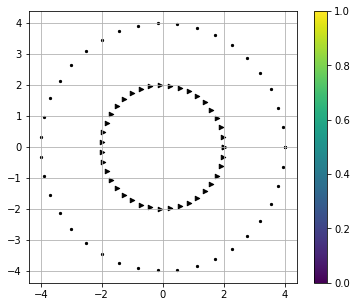

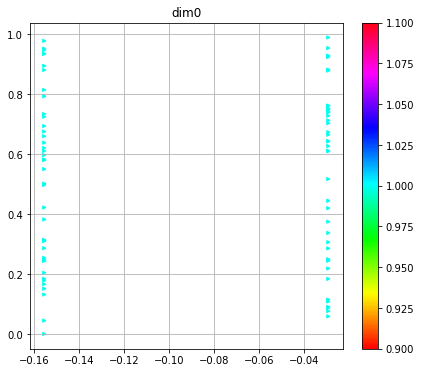

In [ ]:
n = 40
theta = np.linspace(0, 2*np.pi, n)

x1_1 = 2 * np.cos(theta)
x2_1 = 2 * np.sin(theta)

x1_2 = 4 * np.cos(theta)
x2_2 = 4 * np.sin(theta)

# x1_3 = 6 * np.cos(theta) + 15
# x2_3 = 2 * np.sin(theta)

# x1 = np.hstack([x1_1, x1_2, x1_3])
# x2 = np.hstack([x2_1, x2_2, x2_3])
x1 = np.hstack([x1_1, x1_2])
x2 = np.hstack([x2_1, x2_2])

x = [[x1[j], x2[j]] for j in range(len(x2))]
np.shape(x)

y = np.hstack([np.ones(n), np.zeros(n)])


color_label = np.hstack([np.ones(1)*1.5, y[1:]]) 
color_label = np.ones(n*2)
# color_label = np.hstack([np.ones(n)*1.0, np.ones(n)*0.5, np.zeros(n-1), np.ones(1)*1.5]) 

x = np.array(x)
y = np.array(y)
# Displaying images in latent space
plt.figure(figsize=(6,5))
# plt.scatter(x[:50,0], x[:50,1], s=15, c=color_label[:50], cmap='hsv', marker='>')
# plt.scatter(x[50:,0], x[50:,1], s=15, c=color_label[50:], cmap='hsv', marker='*')
plt.scatter(x[:n,0], x[:n,1], s=20, c='black', cmap='hsv', marker='>')
plt.scatter(x[n:,0], x[n:,1], s=20, c='black', cmap='hsv', marker='.')
plt.colorbar()
plt.grid()
# plt.title("dim0")
plt.show()

x, y = shuffle_data(x, y)
# model_TSNE = TSNE(n_components=1)
# proj_TSNE = model_TSNE.fit_transform(x)
# model_isomap = Isomap(n_components=1)
# proj_isomap = model_isomap.fit_transform(x)
model_LLE = LocallyLinearEmbedding(n_components=1,n_neighbors=2)
proj_LLE = model_LLE.fit_transform(x)
x1 = proj_LLE[:,0:1]
# Displaying images in latent space
plt.figure(figsize=(7,6))
# plt.scatter(encoded[:,0], np.random.randn(60000), s=2, c=y_train, cmap='hsv')
plt.scatter(x1, np.random.rand(2*n), s=10, c=color_label, cmap='hsv', marker='>')
plt.colorbar()
plt.grid()
plt.title("dim0")
plt.show()

In [ ]:
def get_chosen_labeled_data(n, x, y):

  preset_labeled_data_x = []
  preset_labeled_data_y = []
  preset_labeled_data_index = []
  for j in range(10):
    sum = 0
    counter = 0
    for i in range(len(y)):
      if y[i] == j:
        sum += proj[i]
        counter += 1

    av = sum/counter

    min_dis = 10000.0
    min_index = 10000.0
    for i in range(len(y)):
      new_dis = np.sqrt(np.sum(np.square(proj[i] - av)))
      if new_dis < min_dis:
        if y[i] == j:
          min_dis = new_dis
          min_index = i

    # plt.imshow(x[min_index])
    # print(av)
    # print(proj[min_index])
    # print(min_index)
    preset_labeled_data_x.append(x[min_index])
    preset_labeled_data_y.append(y[min_index])
    preset_labeled_data_index.append(min_index)
  
  times = int(n/10)+1
  # print(preset_labeled_data_y)
  preset_labeled_data_x_repeated = (preset_labeled_data_x*times)[:n]
  preset_labeled_data_y_repeated = (preset_labeled_data_y*times)[:n]

  return preset_labeled_data_x_repeated, preset_labeled_data_y_repeated, preset_labeled_data_x, preset_labeled_data_index

def get_labeled_data(n_l, n, x, y):
  labeled_data_x = x[:n_l].tolist()
  labeled_data_y = y[:n_l].tolist()

  times = int(n/n_l)+1
  labeled_data_x_repeated = (labeled_data_x*times)[:n]
  labeled_data_y_repeated = (labeled_data_y*times)[:n]
  labeled_data_index = np.linspace(0, n_l-1, n_l, dtype=int).tolist()

  return labeled_data_x_repeated, labeled_data_y_repeated, labeled_data_x, labeled_data_index

  # constract laplacian graph
def get_fine_tuning_training_set(n, x, g):
  anchor_index = np.random.randint(0, len(g), n)
  another_index = np.random.randint(0, len(g), n)

  anchor = []
  another = []
  similarity = []

  for i in range(n):
    anchor.append(x[anchor_index[i]])
    another.append(x[another_index[i]])
    similarity.append(g[anchor_index[i], another_index[i]])

  return anchor, another, similarity

  
def get_fine_tuning_training_set2(n, x, g, preset_labeled_data_index):
  anchor_index = np.random.randint(0, len(g), n)
  another_index = np.random.randint(0, len(g), n)
  x_index = (preset_labeled_data_index*(int(n/(len(preset_labeled_data_index)))+1))[:n]
  anchor = []
  another = []
  similarity_anchor_another = []
  similarity_anchor_x = []
  similarity_another_x = []

  for i in range(n):
    anchor.append(x[anchor_index[i]])
    another.append(x[another_index[i]])
    similarity_anchor_another.append(g[anchor_index[i], another_index[i]])
    similarity_anchor_x.append(g[anchor_index[i], x_index[i]])
    similarity_another_x.append(g[x_index[i], another_index[i]])

  return anchor, another, similarity_anchor_another, similarity_anchor_x, similarity_another_x

def get_filted_fine_tuning_training_set(n, x, proj, preset_labeled_data_x, preset_labeled_data_index):
  anchor_index = np.random.randint(0, len(preset_labeled_data_index), n)
  another_index = np.random.randint(0, len(proj), n)

  anchor = []
  another = []
  similarity = []

  for i in range(n):
    anchor_element = preset_labeled_data_x[anchor_index[i]]
    another_element = x[another_index[i]]
    anchor.append(anchor_element)
    another.append(another_element)
    similarity.append(proj_2_similarity(proj[preset_labeled_data_index[anchor_index[i]]], proj[another_index[i]]))

  return anchor, another, similarity

def get_training_set(n, n_l, x, y, g):
  # x, y = shuffle_data(x, y)
  x_train, y_train = get_labeled_training_set(n, n_l, x, y)
  anchor, another, similarity = get_fine_tuning_training_set(n, x, g)
  return x_train, y_train, anchor, another, similarity

def get_training_set_with_chosen_labeled_data(n, n_l, x, y, proj, g):
  # x_train, y_train, preset_labeled_data_x, preset_labeled_data_index = get_chosen_labeled_data(n, x, y)
  x_train, y_train, preset_labeled_data_x, preset_labeled_data_index = get_labeled_data(n_l, n, x, y)
  anchor, another, similarity_anchor_another, similarity_anchor_x, similarity_another_x = get_fine_tuning_training_set2(n, x, g, preset_labeled_data_index)
  return x_train, y_train, anchor, another, similarity_anchor_another, similarity_anchor_x, similarity_another_x

In [ ]:
def square_loss(y_actual,y_pred):
  my_loss= (y_actual-y_pred)**2
  return my_loss

def unsupervised_loss(actual_similarity,pred_distance):
  my_loss2= actual_similarity * pred_distance
  return my_loss2 * 0.1

def my_euclidean_distance(vectors):
	(featsA, featsB) = vectors
	sumSquared = K.sum(K.square(featsA - featsB), axis=1, keepdims=True)
	return K.sqrt(K.maximum(sumSquared, K.epsilon()))

def get_second_model():
  input_x = Input((2,))
  input_anchor = Input((2,))
  input_another = Input((2,))

  input_encoder = Input((2,))
  encode = Dense(10, activation='relu')(input_encoder)
  encode = Dense(4, activation='relu')(encode)
  output_encoder = Dense(1, activation='sigmoid')(encode)
  encoder = Model(input_encoder, output_encoder)

  x_pred = encoder(input_x)
  anchor_pred = encoder(input_anchor)
  another_pred = encoder(input_another)
  similarity_anchor_another = Lambda(my_euclidean_distance)([anchor_pred, another_pred])
  similarity_anchor_x = Lambda(my_euclidean_distance)([anchor_pred, x_pred])
  similarity_another_x = Lambda(my_euclidean_distance)([x_pred, another_pred])

  model = Model([input_x, input_anchor, input_another], [x_pred, similarity_anchor_another, similarity_anchor_x, similarity_another_x])
  model.compile(optimizer="adam",loss=[square_loss, unsupervised_loss, unsupervised_loss, unsupervised_loss],
                # metrics=["accuracy"]
                )

  return model, encoder

def get_first_model():
  input_x = Input((2,))
  input_p = Input((1,))
  input_mix = concatenate([input_x, input_p])
  im = Dense(10, activation='relu')(input_mix)
  im = Dense(4, activation='relu')(im)
  output = Dense(2, activation='sigmoid')(im)

  model = Model([input_x, input_p], output)
  model.compile(optimizer="adam",loss=tf.keras.losses.sparse_categorical_crossentropy,metrics=["accuracy"])
  return model

In [ ]:
# check whether you have labeled data in both classes
y[:10]

array([1., 0., 1., 0., 0., 1., 1., 1., 0., 1.])

In [ ]:
n_l = 10

model = get_first_model()
history = model.fit([x[:n_l], proj_LLE[:n_l]], y[:n_l],
                    epochs=5000, batch_size=4,
                    validation_data=([x[n_l:], proj_LLE[n_l:]], y[n_l:]),
                    )


Train on 10 samples, validate on 70 samples
Epoch 1/5000
 4/10 [===========>..................] - ETA: 0s - loss: 0.7594 - accuracy: 0.7500

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2057: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


流式输出内容被截断，只能显示最后 5000 行内容。
10/10 [==============================] - 0s 6ms/sample - loss: 6.6229e-05 - accuracy: 1.0000 - val_loss: 1.1055 - val_accuracy: 0.7857
Epoch 2502/5000
10/10 [==============================] - 0s 6ms/sample - loss: 6.6157e-05 - accuracy: 1.0000 - val_loss: 1.1056 - val_accuracy: 0.7857
Epoch 2503/5000
10/10 [==============================] - 0s 7ms/sample - loss: 6.6074e-05 - accuracy: 1.0000 - val_loss: 1.1057 - val_accuracy: 0.7857
Epoch 2504/5000
10/10 [==============================] - 0s 6ms/sample - loss: 6.5907e-05 - accuracy: 1.0000 - val_loss: 1.1057 - val_accuracy: 0.7857
Epoch 2505/5000
10/10 [==============================] - 0s 7ms/sample - loss: 6.5764e-05 - accuracy: 1.0000 - val_loss: 1.1058 - val_accuracy: 0.7857
Epoch 2506/5000
10/10 [==============================] - 0s 7ms/sample - loss: 6.5633e-05 - accuracy: 1.0000 - val_loss: 1.1060 - val_accuracy: 0.7857
Epoch 2507/5000
10/10 [==============================] - 0s 8ms/sample - loss: 6.54

In [ ]:
def laplacian_graph(proj):
  c = 0.05
  # c = 0.02
  size = len(proj)
  g = np.zeros([size, size])
  for i in tqdm(range(size)):
    for j in range(size):
      dis = np.sqrt(np.sum(np.square(proj[i] - proj[j])))
      # print(dis)
      if dis > 0.1:
        g[i][j] = 0
      else:
        g[i][j] = np.exp(-((dis)**2/c))
  return g
g = laplacian_graph(proj_LLE)

100%|██████████| 80/80 [00:00<00:00, 749.06it/s]


In [ ]:
n = 40
n_l = 2
x_train, y_train, anchor, another, similarity_anchor_another, similarity_anchor_x, similarity_another_x = get_training_set_with_chosen_labeled_data(n, n_l, x, y, proj_LLE, g)

In [ ]:
y_train[:10]

[1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 0.0]

In [ ]:
print(np.shape(x_train))
# np.shape(y)


model, encoder = get_second_model()
history = model.fit([x_train, anchor, another], [y_train, similarity_anchor_another, similarity_anchor_x, similarity_another_x],
                    epochs=1000, batch_size=32,
                    # validation_data=(X_0_and_1[n_labeled:n_labeled+500], Y_0_and_1[n_labeled:n_labeled+500]),
                    )
# accuracy = history.history['val_accuracy']
# without_manifold.append(np.average(heapq.nlargest(int(10), accuracy)))

(40, 2)
Train on 40 samples
Epoch 1/1000
40/40 [==============================] - 0s 6ms/sample - loss: 0.2493 - model_45_loss: 0.2512 - lambda_12_loss: 0.0068 - lambda_13_loss: 0.0044 - lambda_14_loss: 0.0042
Epoch 2/1000
40/40 [==============================] - 0s 333us/sample - loss: 0.2438 - model_45_loss: 0.2195 - lambda_12_loss: 0.0079 - lambda_13_loss: 0.0044 - lambda_14_loss: 0.0043
Epoch 3/1000
40/40 [==============================] - 0s 276us/sample - loss: 0.2383 - model_45_loss: 0.2148 - lambda_12_loss: 0.0065 - lambda_13_loss: 0.0042 - lambda_14_loss: 0.0034
Epoch 4/1000
40/40 [==============================] - 0s 358us/sample - loss: 0.2329 - model_45_loss: 0.2268 - lambda_12_loss: 0.0072 - lambda_13_loss: 0.0040 - lambda_14_loss: 0.0039
Epoch 5/1000
40/40 [==============================] - 0s 359us/sample - loss: 0.2277 - model_45_loss: 0.2217 - lambda_12_loss: 0.0048 - lambda_13_loss: 0.0028 - lambda_14_loss: 0.0044
Epoch 6/1000
40/40 [==============================] - 

  0%|          | 0/50 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
100%|██████████| 50/50 [00:05<00:00,  9.50it/s]


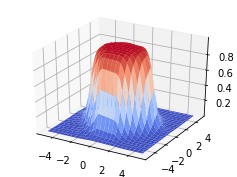

In [ ]:
test_size = 50
x_axis = np.linspace(-5.0, 5.0, test_size)
y_axis = np.linspace(-5.0, 5.0, test_size)
# x_axis = np.linspace(-10.0, 5.0, test_size)
# y_axis = np.linspace(-10.0, 5.0, test_size)
x_axis, y_axis = np.meshgrid(x_axis, y_axis)
pred = np.zeros([test_size, test_size])

for i in tqdm(range(test_size)):
  for j in range(test_size):
    t = [[x_axis[i][j], y_axis[i][j]]]
    t = np.reshape(t, [-1, 2])
    pred[i][j] = encoder.predict(t)[0]


from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(4,3))
ax = fig.gca(projection='3d')
surf = ax.plot_surface(x_axis, y_axis, pred, rstride=2, cstride=2, cmap=plt.cm.coolwarm, linewidth=0.5, antialiased=True)
# ax.set_xlabel('x1')
# ax.set_ylabel('x2')
ax.set_zlabel('prediction')

plt.show()